## Introduction

WeRateDogs is a Twitter account, started in Nov., 2015, which rates people's dogs with a humorous comment about the dog. Dogs are rated on a scale of one to ten, but are invariably given ratings in excess of the maximum, such as "13/10". 

The goal of this project is wrangling WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import requests
import json
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import re
import seaborn as sb

%matplotlib inline

## Data Wrangling

Data comes from three sources:
1. Enhanced Twitter Archive, provided by the program, contains basic tweet data for all 5000+ of their tweets, but not everything
2. Additional data via Twitter API
3. Image Predictions File, provided by the program, is a table of full of image predictions (the top three only) alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction (numbered 1 to 4 since tweets can have up to four images). 

Data from all three sources will be gathered, assessed and cleaned.  

### Gather

#### Image Predictions File: image-predictions.tsv

In [2]:
# download image-predictions.tsv programmatically 
r = requests.get('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')
if(r.status_code == 200):
    with open('image-predictions.tsv', 'w') as outfile:
        outfile.write(r.text)

In [3]:
df_imgpredict = pd.read_csv('image-predictions.tsv', sep = '\t')
df_imgpredict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Enhanced Twitter Archive: twitter-archive-enhanced.csv

In [4]:
df_tweetarchive = pd.read_csv('twitter-archive-enhanced.csv')
df_tweetarchive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Additional Data via Twitter API

In [109]:
consumer_key = 'XXX'
consumer_secret = 'XXX'
access_token = 'XXX'
access_secret = 'XXX'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit = True)

In [111]:
# query Twitter's API for JSON data for each tweet in the Twitter archive by tweet_id 
tweet_ids = df_tweetarchive.tweet_id

count = 0
tweet_fails = {}
starttime = timer()
# Save each tweet's returned JSON as a new line in tweet_json.txt
# with open('tweet_json.txt', 'w') as outfile:
with open('tweet_json_full.txt', 'w') as outfile:
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode = 'extended')
            print("Succeed")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            tweet_fails[tweet_id] = e
            pass
endtime = timer()
print(endtime - starttime)
print(tweet_fails)

1: 892420643555336193
Succeed
2: 892177421306343426
Succeed
3: 891815181378084864
Succeed
4: 891689557279858688
Succeed
5: 891327558926688256
Succeed
6: 891087950875897856
Succeed
7: 890971913173991426
Succeed
8: 890729181411237888
Succeed
9: 890609185150312448
Succeed
10: 890240255349198849
Succeed
11: 890006608113172480
Succeed
12: 889880896479866881
Succeed
13: 889665388333682689
Succeed
14: 889638837579907072
Succeed
15: 889531135344209921
Succeed
16: 889278841981685760
Succeed
17: 888917238123831296
Succeed
18: 888804989199671297
Succeed
19: 888554962724278272
Succeed
20: 888202515573088257
Fail
21: 888078434458587136
Succeed
22: 887705289381826560
Succeed
23: 887517139158093824
Succeed
24: 887473957103951883
Succeed
25: 887343217045368832
Succeed
26: 887101392804085760
Succeed
27: 886983233522544640
Succeed
28: 886736880519319552
Succeed
29: 886680336477933568
Succeed
30: 886366144734445568
Succeed
31: 886267009285017600
Succeed
32: 886258384151887873
Succeed
33: 8860541600590725

Fail
262: 842846295480000512
Succeed
263: 842765311967449089
Succeed
264: 842535590457499648
Succeed
265: 842163532590374912
Succeed
266: 842115215311396866
Succeed
267: 841833993020538882
Succeed
268: 841680585030541313
Succeed
269: 841439858740625411
Succeed
270: 841320156043304961
Succeed
271: 841314665196081154
Succeed
272: 841077006473256960
Succeed
273: 840761248237133825
Succeed
274: 840728873075638272
Succeed
275: 840698636975636481
Succeed
276: 840696689258311684
Succeed
277: 840632337062862849
Succeed
278: 840370681858686976
Succeed
279: 840268004936019968
Succeed
280: 839990271299457024
Succeed
281: 839549326359670784
Succeed
282: 839290600511926273
Succeed
283: 839239871831150596
Succeed
284: 838952994649550848
Succeed
285: 838921590096166913
Succeed
286: 838916489579200512
Succeed
287: 838831947270979586
Succeed
288: 838561493054533637
Succeed
289: 838476387338051585
Succeed
290: 838201503651401729
Succeed
291: 838150277551247360
Succeed
292: 838085839343206401
Succeed
293

Succeed
519: 810657578271330305
Succeed
520: 810284430598270976
Succeed
521: 810254108431155201
Succeed
522: 809920764300447744
Succeed
523: 809808892968534016
Succeed
524: 809448704142938112
Succeed
525: 809220051211603969
Succeed
526: 809084759137812480
Succeed
527: 808838249661788160
Succeed
528: 808733504066486276
Succeed
529: 808501579447930884
Succeed
530: 808344865868283904
Succeed
531: 808134635716833280
Succeed
532: 808106460588765185
Succeed
533: 808001312164028416
Succeed
534: 807621403335917568
Succeed
535: 807106840509214720
Succeed
536: 807059379405148160
Succeed
537: 807010152071229440
Succeed
538: 806629075125202948
Succeed
539: 806620845233815552
Succeed
540: 806576416489959424
Succeed
541: 806542213899489280
Succeed
542: 806242860592926720
Succeed
543: 806219024703037440
Succeed
544: 805958939288408065
Succeed
545: 805932879469572096
Succeed
546: 805826884734976000
Succeed
547: 805823200554876929
Succeed
548: 805520635690676224
Succeed
549: 805487436403003392
Succeed


Succeed
777: 776113305656188928
Succeed
778: 776088319444877312
Succeed
779: 775898661951791106
Succeed
780: 775842724423557120
Succeed
781: 775733305207554048
Succeed
782: 775729183532220416
Succeed
783: 775364825476165632
Succeed
784: 775350846108426240
Succeed
785: 775096608509886464
Fail
786: 775085132600442880
Succeed
787: 774757898236878852
Succeed
788: 774639387460112384
Succeed
789: 774314403806253056
Succeed
790: 773985732834758656
Succeed
791: 773922284943896577
Succeed
792: 773704687002451968
Succeed
793: 773670353721753600
Succeed
794: 773547596996571136
Succeed
795: 773336787167145985
Succeed
796: 773308824254029826
Succeed
797: 773247561583001600
Succeed
798: 773191612633579521
Succeed
799: 772877495989305348
Succeed
800: 772826264096874500
Succeed
801: 772615324260794368
Succeed
802: 772581559778025472
Succeed
803: 772193107915964416
Succeed
804: 772152991789019136
Succeed
805: 772117678702071809
Succeed
806: 772114945936949249
Succeed
807: 772102971039580160
Succeed
808

Succeed
1034: 745074613265149952
Succeed
1035: 745057283344719872
Succeed
1036: 744995568523612160
Succeed
1037: 744971049620602880
Succeed
1038: 744709971296780288
Succeed
1039: 744334592493166593
Succeed
1040: 744234799360020481
Succeed
1041: 744223424764059648
Succeed
1042: 743980027717509120
Succeed
1043: 743895849529389061
Succeed
1044: 743835915802583040
Succeed
1045: 743609206067040256
Succeed
1046: 743595368194129920
Succeed
1047: 743545585370791937
Succeed
1048: 743510151680958465
Succeed
1049: 743253157753532416
Succeed
1050: 743222593470234624
Succeed
1051: 743210557239623680
Succeed
1052: 742534281772302336
Succeed
1053: 742528092657332225
Succeed
1054: 742465774154047488
Succeed
1055: 742423170473463808
Succeed
1056: 742385895052087300
Succeed
1057: 742161199639494656
Succeed
1058: 742150209887731712
Succeed
1059: 741793263812808706
Succeed
1060: 741743634094141440
Succeed
1061: 741438259667034112
Succeed
1062: 741303864243200000
Succeed
1063: 741099773336379392
Succeed
10

Succeed
1284: 708711088997666817
Succeed
1285: 708479650088034305
Succeed
1286: 708469915515297792
Succeed
1287: 708400866336894977
Succeed
1288: 708356463048204288
Succeed
1289: 708349470027751425
Succeed
1290: 708149363256774660
Succeed
1291: 708130923141795840
Succeed
1292: 708119489313951744
Succeed
1293: 708109389455101952
Succeed
1294: 708026248782585858
Succeed
1295: 707995814724026368
Succeed
1296: 707983188426153984
Succeed
1297: 707969809498152960
Succeed
1298: 707776935007539200
Succeed
1299: 707741517457260545
Succeed
1300: 707738799544082433
Succeed
1301: 707693576495472641
Succeed
1302: 707629649552134146
Succeed
1303: 707610948723478529
Succeed
1304: 707420581654872064
Succeed
1305: 707411934438625280
Succeed
1306: 707387676719185920
Succeed
1307: 707377100785885184
Succeed
1308: 707315916783140866
Succeed
1309: 707297311098011648
Succeed
1310: 707059547140169728
Succeed
1311: 707038192327901184
Succeed
1312: 707021089608753152
Succeed
1313: 707014260413456384
Succeed
13

Succeed
1533: 690005060500217858
Succeed
1534: 689999384604450816
Succeed
1535: 689993469801164801
Succeed
1536: 689977555533848577
Succeed
1537: 689905486972461056
Succeed
1538: 689877686181715968
Succeed
1539: 689835978131935233
Succeed
1540: 689661964914655233
Succeed
1541: 689659372465688576
Succeed
1542: 689623661272240129
Succeed
1543: 689599056876867584
Succeed
1544: 689557536375177216
Succeed
1545: 689517482558820352
Succeed
1546: 689289219123089408
Succeed
1547: 689283819090870273
Succeed
1548: 689280876073582592
Succeed
1549: 689275259254616065
Succeed
1550: 689255633275777024
Succeed
1551: 689154315265683456
Succeed
1552: 689143371370250240
Succeed
1553: 688916208532455424
Succeed
1554: 688908934925697024
Succeed
1555: 688898160958271489
Succeed
1556: 688894073864884227
Succeed
1557: 688828561667567616
Succeed
1558: 688804835492233216
Succeed
1559: 688789766343622656
Succeed
1560: 688547210804498433
Succeed
1561: 688519176466644993
Succeed
1562: 688385280030670848
Succeed
15

Succeed
1782: 677698403548192770
Succeed
1783: 677687604918272002
Succeed
1784: 677673981332312066
Succeed
1785: 677662372920729601
Succeed
1786: 677644091929329666
Succeed
1787: 677573743309385728
Succeed
1788: 677565715327688705
Succeed
1789: 677557565589463040
Succeed
1790: 677547928504967168
Succeed
1791: 677530072887205888
Succeed
1792: 677335745548390400
Succeed
1793: 677334615166730240
Succeed
1794: 677331501395156992
Succeed
1795: 677328882937298944
Succeed
1796: 677314812125323265
Succeed
1797: 677301033169788928
Succeed
1798: 677269281705472000
Succeed
1799: 677228873407442944
Succeed
1800: 677187300187611136
Succeed
1801: 676975532580409345
Succeed
1802: 676957860086095872
Succeed
1803: 676949632774234114
Succeed
1804: 676948236477857792
Succeed
1805: 676946864479084545
Succeed
1806: 676942428000112642
Succeed
1807: 676936541936185344
Succeed
1808: 676916996760600576
Succeed
1809: 676897532954456065
Succeed
1810: 676864501615042560
Succeed
1811: 676821958043033607
Succeed
18

Succeed
2031: 671789708968640512
Succeed
2032: 671768281401958400
Succeed
2033: 671763349865160704
Succeed
2034: 671744970634719232
Succeed
2035: 671743150407421952
Succeed
2036: 671735591348891648
Succeed
2037: 671729906628341761
Succeed
2038: 671561002136281088
Succeed
2039: 671550332464455680
Succeed
2040: 671547767500775424
Succeed
2041: 671544874165002241
Succeed
2042: 671542985629241344
Succeed
2043: 671538301157904385
Succeed
2044: 671536543010570240
Succeed
2045: 671533943490011136
Succeed
2046: 671528761649688577
Succeed
2047: 671520732782923777
Succeed
2048: 671518598289059840
Succeed
2049: 671511350426865664
Succeed
2050: 671504605491109889
Succeed
2051: 671497587707535361
Succeed
2052: 671488513339211776
Succeed
2053: 671486386088865792
Succeed
2054: 671485057807351808
Succeed
2055: 671390180817915904
Succeed
2056: 671362598324076544
Succeed
2057: 671357843010908160
Succeed
2058: 671355857343524864
Succeed
2059: 671347597085433856
Succeed
2060: 671186162933985280
Succeed
20

Succeed
2281: 667393430834667520
Succeed
2282: 667369227918143488
Succeed
2283: 667211855547486208
Succeed
2284: 667200525029539841
Succeed
2285: 667192066997374976
Succeed
2286: 667188689915760640
Succeed
2287: 667182792070062081
Succeed
2288: 667177989038297088
Succeed
2289: 667176164155375616
Succeed
2290: 667174963120574464
Succeed
2291: 667171260800061440
Succeed
2292: 667165590075940865
Succeed
2293: 667160273090932737
Succeed
2294: 667152164079423490
Succeed
2295: 667138269671505920
Succeed
2296: 667119796878725120
Succeed
2297: 667090893657276420
Succeed
2298: 667073648344346624
Succeed
2299: 667070482143944705
Succeed
2300: 667065535570550784
Succeed
2301: 667062181243039745
Succeed
2302: 667044094246576128
Succeed
2303: 667012601033924608
Succeed
2304: 666996132027977728
Succeed
2305: 666983947667116034
Succeed
2306: 666837028449972224
Succeed
2307: 666835007768551424
Succeed
2308: 666826780179869698
Succeed
2309: 666817836334096384
Succeed
2310: 666804364988780544
Succeed
23

Status of tweets (total of 16) can't be retrieved via Twitter API:  888202515573088257, 873697596434513921, 872668790621863937, 869988702071779329, 866816280283807744, 861769973181624320, 845459076796616705, 842892208864923648, 837012587749474308, 827228250799742977, 812747805718642688, 802247111496568832, 775096608509886464, 770743923962707968, 754011816964026368, 680055455951884288, 

In [5]:
# read tweet_json.txt line by line
# for each line:
## 1\ use json.loads to deserialie the line to a Python dictory
## 2\ create a new dict for the selected attributes: id, retweet_count, favorite_count 
## 3\ add the newly created dict into dicts
# construct DataFrame from dicts

tweets_api = []
attributes = ['id', 'retweet_count', 'favorite_count']
with open('tweet_json.txt') as infile:
    for line in infile:
        tweet  = json.loads(line)
        # print(json.dumps(tweet, indent=2, sort_keys=True))
        tweet_sel = {}
        for attribute in attributes:
            tweet_sel[attribute] = tweet[attribute]
        tweets_api.append(tweet_sel)

df_tweetapi = pd.DataFrame.from_dict(tweets_api)
df_tweetapi = df_tweetapi[attributes]
df_tweetapi.tail()

,id,retweet_count,favorite_count
2335,666049248165822465,41,107
2336,666044226329800704,139,294
2337,666033412701032449,43,123
2338,666029285002620928,47,127
2339,666020888022790149,502,2538


## Assess

In [6]:
pd.set_option('display.max_colwidth', -1)

#### df_tweetarchive (twitter_archive_enhanced.csv)

In [19]:
df_tweetarchive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [20]:
df_tweetarchive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1023,746521445350707200,NaN,NaN,2016-06-25 01:52:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Shaggy. He knows exactly how to solve the puzzle but can't talk. All he wants to do is help. 10/10 great guy https:/…,6.678667e+17,4.196984e+09,2015-11-21 00:46:50 +0000,https://twitter.com/dog_rates/status/667866724293877760/photo/1,10,10,Shaggy,None,None,None,None
876,761004547850530816,NaN,NaN,2016-08-04 01:03:17 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,NaN,NaN,NaN,https://twitter.com/dog_rates/status/761004547850530816/photo/1,11,10,Bo,None,None,None,None
1173,720340705894408192,NaN,NaN,2016-04-13 19:59:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Derek. He just got balled on. Can't even get up. Poor thing. 10/10 hang in there pupper https://t.co/BIRRF3bcWH,NaN,NaN,NaN,https://twitter.com/dog_rates/status/720340705894408192/photo/1,10,10,Derek,None,None,pupper,None
736,780931614150983680,NaN,NaN,2016-09-28 00:46:20 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I want to finally rate this iconic puppo who thinks the parade is all for him. 13/10 would absolutely attend https://t.co/5dUYOu4b8d,NaN,NaN,NaN,https://twitter.com/dog_rates/status/780931614150983680/photo/1,13,10,None,None,None,None,puppo
2036,671729906628341761,6.715610e+17,4.196984e+09,2015-12-01 16:37:44 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I'm just going to leave this one here as well. 13/10 https://t.co/DaD5SyajWt,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671729906628341761/photo/1,13,10,None,None,None,None,None


1. Upon the first glimpse, there are missing values in *in_reply_to_status_id*, *in_reply_to_user_id*. Per Tweet Data Dictionary (https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html): if the represented Tweet is a reply, these fields will contain the integer and string representation of the original Tweet’s ID respectively.
2. Upon the first glimpse, there are missing values in *retweeted_status_id*, *retweeted_status_user_id*, *retweeted_status_timestamp*. Per Tweet Data Dictionary: Retweets can be distinguished from typical Tweets by the existence of a retweeted_status attribute. This attribute contains a representation of the original Tweet that was retweeted
3. Per 'Data Tidying' (https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.htmlColumn), column headers *doggo*, *floofer*, *pupper*, *puppo* are values, not variable names. (**Tidiness**)

In [21]:
df_tweetarchive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

1. Upon the first glimpse, there are missing values in *expanded_urls*. Per Tweet Data Dictionary (https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html): The entities section will contain a media array containing a single media object if any media object has been ‘attached’ to the Tweet. If no native media has been attached, there will be no media array in the entities. expanded_url is an expanded version of display_url. Links to the media display page
2. *timestamp* is string instead of datetime. (**Quality**)
3. *retweeted_status_id*, *retweeted_status_user_id*, *in_reply_to_status_id*, *in_reply_to_user_id* are float instead of integer. (**Quality**)
4. *retweeted_status_timestamp* is also string instead of datetime (**Quality**). 

In [22]:
df_tweetarchive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


Per Wiki (https://en.wikipedia.org/wiki/WeRateDogs): Dogs are rated on a scale of one to ten, but are invariably given ratings in excess of the maximum, such as "13/10". Also per the project keypoints: The fact that the rating numerators are greater than the denominators does not need to be cleaned.

However, the minimum (0) and the maximum (170) rating_denominator, the minimum (0) and the maximum (1776) rating_numerator don't sound reasonable and deserve a closer look. 

In [23]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull() & (df_tweetarchive.rating_denominator != 10)][['tweet_id', 'text', 'rating_denominator']]

,tweet_id,text,rating_denominator
313,835246439529840640,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",0
342,832088576586297345,@docmisterio account started on 11/15/15,15
433,820690176645140481,The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,70
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,7
902,758467244762497024,Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,150
1068,740373189193256964,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",11
1120,731156023742988288,Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,170
1165,722974582966214656,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,20
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,50
1228,713900603437621249,Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,90


Observations
1. Numbers which actually are not ratings are taken as ratings. For examples, 7/11 in tweet 682962037429899265 (it refers to the convenience store 7-Eleven), 24/7 in tweet 810984652412424192 (it actually means 24 hours a day and 7 days a week), 9/11 in tweet 740373189193256964 (it is a date  ). (**Quality**)
2. Some users are not following the 1-10 rating scale. For example, 144/120 in tweet 677716515794329600). 

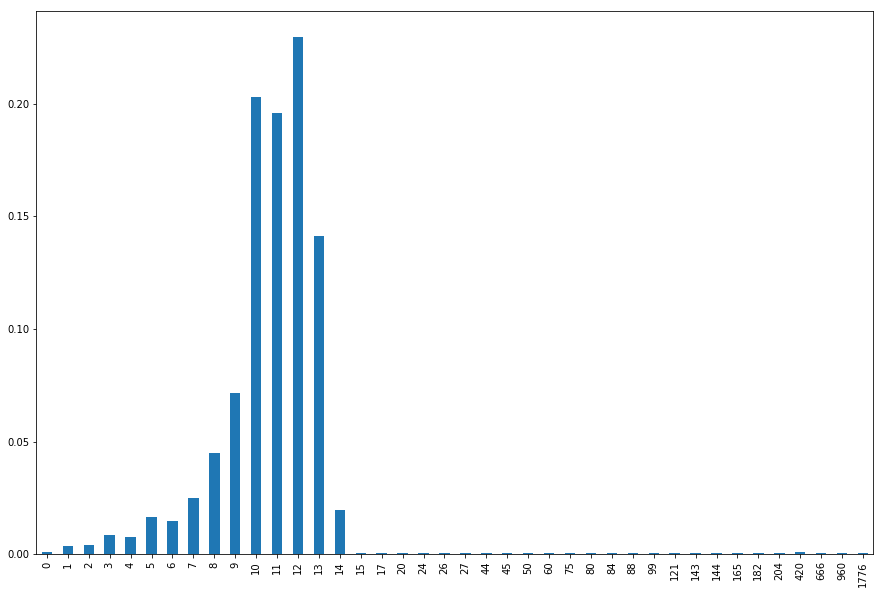

In [24]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull()].rating_numerator.value_counts(normalize = True).sort_index().plot(kind = 'bar', figsize = [15, 10])

The plot shows that rating_denominator that is less than 1 and greater than 14 is rare. Look further ...

In [25]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull() & ((df_tweetarchive.rating_numerator < 1) | (df_tweetarchive.rating_numerator > 14))]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10",NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
291,838085839343206401,8.380855e+17,2.894131e+09,2017-03-04 17:56:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@bragg6of8 @Andy_Pace_ we are still looking for the first 15/10,NaN,NaN,NaN,NaN,15,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None


Observations
1. Some ratings are decimal (e.g. 11.27/10 in tweet 778027034220126208, 9.75/10 in tweet 786709082849828864) and are not extracted correctly. It's definitely reasonable to have decimal ratings. (**Quality**)
2. Numbers which are actually not ratings are taken as ratings. For examples, 24/7 in tweet 810984652412424192 (it means 24 hours a day, 7 days a week), 50/50 in tweet 716439118184652801 (this actually is talking about equally split). (**Quality**)
3. Some tweets contain more than one ratings, and the first one, by default, is taken as ratingts while it is not. For example, tweet 835246439529840640 contains 2 ratings, and the 2nd is the true rating (Note - this tweet is a reply to another tweet). (**Quality**)

In [26]:
df_tweetarchive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

*source* is html anchor tag. Per Tweet Data Dictionary (https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html), *source* is the utility used to post the Tweet - the text in the tag is what we really care about. (**Quality**)

In [27]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull()].name.value_counts()

None         680
a            55 
Charlie      11 
Lucy         11 
Cooper       10 
Oliver       10 
Tucker       9  
Penny        9  
Sadie        8  
the          8  
Winston      8  
Lola         8  
Daisy        7  
Toby         7  
Oscar        6  
Bo           6  
Jax          6  
Bella        6  
Bailey       6  
an           6  
Stanley      6  
Koda         6  
Rusty        5  
Buddy        5  
Milo         5  
Louis        5  
Scout        5  
Leo          5  
Bentley      5  
Chester      5  
            ..  
Philbert     1  
Margo        1  
Peanut       1  
Jeffrie      1  
Arlo         1  
Stubert      1  
Gerbald      1  
Pablo        1  
Wishes       1  
Arlen        1  
Akumi        1  
Enchilada    1  
Rolf         1  
Kyro         1  
Rumpole      1  
Leonidas     1  
Grizzie      1  
Aubie        1  
Obie         1  
Rueben       1  
Lillie       1  
Remy         1  
Finnegus     1  
Filup        1  
Dudley       1  
Napolean     1  
Arnold       1  
Kara         1

Observations
1. No name is found in 680 tweets
2. Lots of invalid names such as 'a', 'an', 'the'

In [46]:
names_invalid = ['a', 'the', 'an']
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull() & (df_tweetarchive.name.isin(names_invalid))][['tweet_id','text', 'name']]

,tweet_id,text,name
56,881536004380872706,Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,a
649,792913359805018113,Here is a perfect example of someone who has their priorities in order. 13/10 for both owner and Forrest https://t.co/LRyMrU7Wfq,a
801,772581559778025472,Guys this is getting so out of hand. We only rate dogs. This is a Galapagos Speed Panda. Pls only send dogs... 10/10 https://t.co/8lpAGaZRFn,a
1002,747885874273214464,This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW,a
1004,747816857231626240,Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R,a
1017,746872823977771008,This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2,a
1025,746369468511756288,This is an Iraqi Speed Kangaroo. It is not a dog. Please only send in dogs. I'm very angry with all of you ...9/10 https://t.co/5qpBTTpgUt,an
1049,743222593470234624,This is a very rare Great Alaskan Bush Pupper. Hard to stumble upon without spooking. 12/10 would pet passionately https://t.co/xOBKCdpzaa,a
1193,717537687239008257,People please. This is a Deadly Mediterranean Plop T-Rex. We only rate dogs. Only send in dogs. Thanks you... 11/10 https://t.co/2ATDsgHD4n,a
1207,715733265223708672,This is a taco. We only rate dogs. Please only send in dogs. Dogs are what we rate. Not tacos. Thank you... 10/10 https://t.co/cxl6xGY8B9,a


Observations
1. Apparently, these invalid names (a, an, the) are extracted using pattern 'is xxx' where xxx is a/an/the. For example, 'This is a golden Buckminsterfullerene named Johm' in tweet 666701168228331520
2. Where these invalid names are extracted, we may be able to find dog's name in 'named xxx' where xxx is dog's name. For example,  'This is a purebred Bacardi named Octaviath' in tweet 666781792255496192

In [29]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull() & (df_tweetarchive.name == 'None')][['tweet_id','text', 'name']]

,tweet_id,text,name
5,891087950875897856,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,None
7,890729181411237888,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,None
12,889665388333682689,Here's a puppo that seems to be on the fence about something haha no but seriously someone help her. 13/10 https://t.co/BxvuXk0UCm,None
24,887343217045368832,You may not have known you needed to see this today. 13/10 please enjoy (IG: emmylouroo) https://t.co/WZqNqygEyV,None
25,887101392804085760,This... is a Jubilant Antarctic House Bear. We only rate dogs. Please only send dogs. Thank you... 12/10 would suffocate in floof https://t.co/4Ad1jzJSdp,None
30,886267009285017600,@NonWhiteHat @MayhewMayhem omg hello tanner you are a scary good boy 12/10 would pet with extreme caution,None
35,885518971528720385,I have a new hero and his name is Howard. 14/10 https://t.co/gzLHboL7Sk,None
37,885167619883638784,Here we have a corgi undercover as a malamute. Pawbably doing important investigative work. Zero control over tongue happenings. 13/10 https://t.co/44ItaMubBf,None
41,884441805382717440,"I present to you, Pup in Hat. Pup in Hat is great for all occasions. Extremely versatile. Compact as h*ck. 14/10 (IG: itselizabethgales) https://t.co/vvBOcC2VdC",None
42,884247878851493888,OMG HE DIDN'T MEAN TO HE WAS JUST TRYING A LITTLE BARKOUR HE'S SUPER SORRY 13/10 WOULD FORGIVE IMMEDIATE https://t.co/uF3pQ8Wubj,None


Examples with invalid names
1. 885518971528720385: I have a new hero and his name is Howard. 
2. 878604707211726852:	Martha is stunning how h*ckin dare you. 
3. 666835007768551424:	These are Peruvian Feldspars. Their names are Cupit and Prencer

In [30]:
df_tweetarchive[df_tweetarchive.retweeted_status_id.isnull() & (df_tweetarchive.name.str.len() < 3) & (~df_tweetarchive.name.isin(names_invalid))][['tweet_id','text', 'name']]

,tweet_id,text,name
393,825876512159186944,This is Mo. No one will push him around in the grocery cart. He's quite pupset about it. 11/10 I volunteer https://t.co/feNwTq12S5,Mo
449,819004803107983360,This is Bo. He was a very good First Doggo. 14/10 would be an absolute honor to pet https://t.co/AdPKrI8BZ1,Bo
553,804026241225523202,This is Bo. He's going to make me cry. 13/10 please get off the bus for him Carly https://t.co/U7FvBZo6Bq,Bo
679,789137962068021249,This is Bo. He's a West Congolese Bugaboop Snuggle. Rather exotic. Master of the head tilt. 12/10 would pay to pet https://t.co/2jwxxtNzoN,Bo
775,776201521193218049,This is O'Malley. That is how he sleeps. Doesn't care what you think about it. 10/10 comfy af https://t.co/Pq150LeRaC,O
820,770414278348247044,Meet Al Cabone. He's a gangsta puppa. Rather h*ckin ruthless. Shows no mercy sometimes. 11/10 pet w extreme caution https://t.co/OUwWbEKOUV,Al
852,765395769549590528,This is my dog. Her name is Zoey. She knows I've been rating other dogs. She's not happy. 13/10 no bias at all https://t.co/ep1NkYoiwB,my
876,761004547850530816,This is Bo and Ty. Bo eats paper and Ty felt left out. 11/10 for both https://t.co/1acHQS8rvK,Bo
978,749996283729883136,This is Bo. He emanates happiness. 12/10 I could cut the freedom with a knife https://t.co/c7LNFt39eR,Bo
1683,681694085539872773,This is Bo. He's a Benedoop Cumbersnatch. Seems frustrated with own feet. Portable as hell. 11/10 very solid pupper https://t.co/TONMhRoQh7,Bo


Examples with invalid names
1. 776201521193218049	This is O'Malley (O)
2. 770414278348247044	Meet Al Cabone. (Al)
3. 765395769549590528	This is my dog. Her name is Zoey. (my)
4. 680085611152338944	This is by far the most coordinated series of pictures (by)

In [31]:
df_tweetarchive[~df_tweetarchive.name.isin(['None', 'a', 'an', 'the'])][['tweet_id','text', 'name']]

,tweet_id,text,name
0,892420643555336193,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,Phineas
1,892177421306343426,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",Tilly
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,Archie
3,891689557279858688,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,Darla
4,891327558926688256,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",Franklin
6,890971913173991426,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,Jax
8,890609185150312448,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,Zoey
9,890240255349198849,This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1bfwz5S2A,Cassie
10,890006608113172480,This is Koda. He is a South Australian deckshark. Deceptively deadly. Frighteningly majestic. 13/10 would risk a petting #BarkWeek https://t.co/dVPW0B0Mme,Koda
11,889880896479866881,This is Bruno. He is a service shark. Only gets out of the water to assist you. 13/10 terrifyingly good boy https://t.co/u1XPQMl29g,Bruno


Examples with invalid names
1. 666411507551481857, 'This is quite the dog', 'quite'
2. 887517139158093824, 'I've yet to rate a Venezuelan Hover Wiener. This is such an honor ...', 'such'

Thoughts on how to clean 'name' later
1. The name usually shows up after 'is', sometimes 'are' if there are more than one dogs. It can also shows up after 'named' or 'Meet'.
2. The first letter of the name is capital.
3. The name may include '
4. When 'are' used, the names appear as XXX and YYY

In [32]:
df_tweetarchive[df_tweetarchive.duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


#### df_tweetapi (tweet_json.txt)

In [33]:
df_tweetapi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2340 entries, 0 to 2339
Data columns (total 3 columns):
id                2340 non-null int64
retweet_count     2340 non-null int64
favorite_count    2340 non-null int64
dtypes: int64(3)
memory usage: 54.9 KB


In [35]:
df_tweetapi.describe()

,id,retweet_count,favorite_count
count,2.340000e+03,2340.000000,2340.000000
mean,7.422176e+17,2931.309402,7966.371368
std,6.832564e+16,4938.130305,12338.050591
min,6.660209e+17,0.000000,0.000000
25%,6.783394e+17,588.750000,1375.500000
50%,7.186224e+17,1369.000000,3465.500000
75%,7.986954e+17,3415.250000,9749.750000
max,8.924206e+17,83716.000000,164376.000000


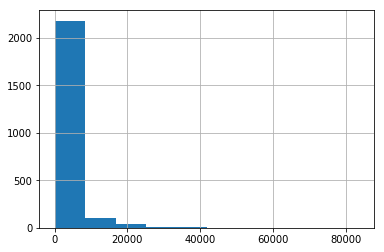

In [36]:
df_tweetapi.retweet_count.hist()

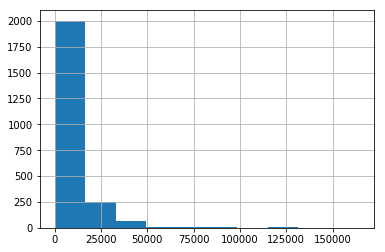

In [37]:
df_tweetapi.favorite_count.hist()

In [38]:
df_tweetapi[df_tweetapi.duplicated()]

,id,retweet_count,favorite_count


#### df_imgpredict (image_predictions.tsv)

In [39]:
df_imgpredict.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [40]:
df_imgpredict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Out of 2356 tweets (including retweets) from the tweet archive, only 2075 have image predictions.

In [41]:
df_imgpredict.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [42]:
df_imgpredict[(~ df_imgpredict.p1_dog) ]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,4.588540e-02,False,terrapin,1.788530e-02,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,1.459380e-02,False,golden_retriever,7.958960e-03,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,3.391940e-02,False,partridge,5.206580e-05,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,8.554740e-02,False,bookcase,7.947970e-02,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,1.525000e-02,False,great_grey_owl,1.320720e-02,False
22,666337882303524864,https://pbs.twimg.com/media/CT9OwFIWEAMuRje.jpg,1,ox,0.416669,False,Newfoundland,2.784070e-01,True,groenendael,1.026430e-01,True
25,666362758909284353,https://pbs.twimg.com/media/CT9lXGsUcAAyUFt.jpg,1,guinea_pig,0.996496,False,skunk,2.402450e-03,False,hamster,4.608630e-04,False
29,666411507551481857,https://pbs.twimg.com/media/CT-RugiWIAELEaq.jpg,1,coho,0.404640,False,barracouta,2.714850e-01,False,gar,1.899450e-01,False
33,666430724426358785,https://pbs.twimg.com/media/CT-jNYqW4AAPi2M.jpg,1,llama,0.505184,False,Irish_terrier,1.041090e-01,True,dingo,6.207120e-02,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,1.671750e-01,True,Chihuahua,8.695060e-02,True


1. Not all images are about dogs. For example, https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg (tweet 666293911632134144) is about a sloth. (**Quality**)
2. In some cases (for example, mulitple objects exist, dogs have costume and etc.), the image classification algorithm fails to detect dogs. For example, in image https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg(tweet 666268910803644416), a dog is sitting in front of a computer behind which a bookcase stands and the computer is playing live-streaming video of the dog! The top 3 predictions are desktop-computer, desk, bookcase. We probably shall use object detection and classification together. (**Quality**)
3. *p1*, *p2*, and *p3* are top 3 predictions. *p1_dog*, *p2_dog*, *p3_dog* tell us if the top 3 predictions are dog or not. In the context of our study, it would make more sense to only include the prediction which is dog and has the highest confidence level - other predictions are noise. For an observation, if none of predictions is dog, it shall be excluded from the analysis related to dog breeds. (**Tidiness**) 


In [43]:
df_imgpredict[df_imgpredict.duplicated()]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


### Quality

#### df_tweetarchive

1. Out of 2356 tweets, only 2075 have image predictions.
2. Out of 2356 tweets, 181 are retweets. 
3. Via Twitter API, 2340 tweets are retrieved via Twitter API (total of 16 failed) 
4. *timestamp* and *retweeted_status_timestamp* are string instead of datetime. 
5. *retweeted_status_id*, *retweeted_status_user_id*, *in_reply_to_status_id*, *in_reply_to_user_id* are float instead of integer and in scientific notation.
6. *rating_denominator* has values other than 10. Looking further:
     1. Some ratings are decimal (e.g. 11.27/10 in tweet 778027034220126208, 9.75/10 in tweet 786709082849828864) and are not extracted correctly. It's definitely reasonable to have decimal ratings. 
     2. Numbers which are actually not ratings are taken as ratings. For examples, 24/7 in tweet 810984652412424192 (it means 24 hours a day, 7 days a week), 50/50 in tweet 716439118184652801 (this actually is talking about equally split).
     3. Some tweets contain more than one ratings, and the first one, by default, is taken as ratingts while it is not. For example, tweet 835246439529840640 contains 2 ratings, and the 2nd is the true rating (Note - this tweet is a reply to another tweet). 
7. rating_numerator has values way beyond normal range. Looking further: 
    1. Some ratings are decimal (e.g. 11.27/10 in tweet 778027034220126208, 9.75/10 in tweet 786709082849828864) and are not extracted correctly. It's definitely reasonable to have decimal ratings. 
    2. Numbers which are actually not ratings are taken as ratings. For examples, 24/7 in tweet 810984652412424192 (it means 24 hours a day, 7 days a week), 50/50 in tweet 716439118184652801 (this actually is talking about equally split). 
    3. Some tweets contain more than one ratings, and the first one, by default, is taken as ratingts while it is not. For example, tweet 835246439529840640 contains 2 ratings, and the 2nd is the true rating (Note - this tweet is a reply to another tweet). 
8. *source* is html anchor tag. Per Tweet Data Dictionary (https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html), *source* is the utility used to post the Tweet - the text in the tag is what we really care about.
9. There are many invalid dog names, such as a, an, the, my and etc.

#### df_imgpredict

1. Not all images are about dogs. For example, https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg (tweet 666293911632134144) is about a sloth. (Quality)
2. In some cases (for example, mulitple objects exist, dogs have costume and etc.), the image classification algorithm fails to detect dogs. For example, in image https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg(tweet 666268910803644416), a dog is sitting in front of a computer behind which a bookcase stands and the computer is playing live-streaming video of the dog! The top 3 predictions are desktop-computer, desk, bookcase. We probably shall use object detection and classification together.

### Tidiess

1. In *df_tweetarchive*, column headers *doggo*, *floofer*, *pupper*, *puppo* are values, not variable names. 
2. In *df_tweetarcive*, column *denominator* is redudant because ratings almost always have a denominator of 10.
3. For image prediction, all we care about is identifying dog breeds. *p1*, *p2*, *p3*, *p1_conf*, *p2_conf*, *p3_conf* *p1_dog*, *p2_dog*, *p3_dog* are data we use to derive results - they are immediate variables, not final variables. 

## Clean

In [7]:
df_tweetarchive_copy = df_tweetarchive.copy()
df_imgpredict_copy = df_imgpredict.copy()
df_tweetapi_copy = df_tweetapi.copy()

<font color=blue>**Issue**</font> - *timestamp* and *retweeted_status_timestamp* in *df_tweetarchive* are string instead of datetime

#### Define

Convert timestamp and retweeted_status_timestamp to datetime 

#### Code

In [8]:
df_tweetarchive_copy.timestamp = pd.to_datetime(df_tweetarchive_copy.timestamp)
df_tweetarchive_copy.retweeted_status_timestamp = pd.to_datetime(df_tweetarchive_copy.retweeted_status_timestamp)

#### Test

In [9]:
df_tweetarchive_copy[['timestamp', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 2 columns):
timestamp                     2356 non-null datetime64[ns]
retweeted_status_timestamp    181 non-null datetime64[ns]
dtypes: datetime64[ns](2)
memory usage: 36.9 KB


<font color=blue>**Issue**</font> - *retweeted_status_id*, *retweeted_status_user_id*, *in_reply_to_status_id*, *in_reply_to_user_id* in *df_tweetarchive* are float and in scientific notation.

#### Define

In Pandas v0.23 and earlier versions, pandas.DataFrame.astype(int) can't be applied to columns containing NaN, and hence, I convert the above columns to string.

#### Code

In [11]:
df_tweetarchive_copy.retweeted_status_id = df_tweetarchive_copy.retweeted_status_id.apply(lambda x: '{:.0f}'.format(x))
df_tweetarchive_copy.retweeted_status_id.replace('nan', np.nan, inplace = True)#

df_tweetarchive_copy.retweeted_status_user_id = df_tweetarchive_copy.retweeted_status_user_id.apply(lambda x: '{:.0f}'.format(x))
df_tweetarchive_copy.retweeted_status_user_id.replace('nan', np.nan, inplace = True)

df_tweetarchive_copy.in_reply_to_status_id = df_tweetarchive_copy.in_reply_to_status_id.apply(lambda x: '{:.0f}'.format(x))
df_tweetarchive_copy.in_reply_to_status_id.replace('nan', np.nan, inplace = True)

df_tweetarchive_copy.in_reply_to_user_id = df_tweetarchive_copy.in_reply_to_user_id.apply(lambda x: '{:.0f}'.format(x))
df_tweetarchive_copy.in_reply_to_user_id.replace('nan', np.nan, inplace = True)

#### Test

In [12]:
df_tweetarchive_copy[df_tweetarchive.name == 'Canela']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,887473957103951872,4196983835,2017-07-19 00:47:34,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None
23,887473957103951883,NaN,NaN,2017-07-19 00:47:34,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,NaN,NaN,NaT,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",13,10,Canela,None,None,None,None


In [13]:
df_tweetarchive_copy[df_tweetarchive_copy.tweet_id == 887473957103951872]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [14]:
df_tweetarchive_copy[['retweeted_status_id', 'retweeted_status_user_id', 'in_reply_to_status_id', 'in_reply_to_user_id']].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 4 columns):
retweeted_status_id         181 non-null object
retweeted_status_user_id    181 non-null object
in_reply_to_status_id       78 non-null object
in_reply_to_user_id         78 non-null object
dtypes: object(4)
memory usage: 73.7+ KB


In [15]:
df_tweetarchive_copy[~ df_tweetarchive_copy.retweeted_status_id.isnull()].retweeted_status_id.sample(5)

615    780931614150983680
574    775733305207554048
298    837011344666812416
749    679462823135686656
310    753039830821511168
Name: retweeted_status_id, dtype: object

In [16]:
df_tweetarchive_copy[~ df_tweetarchive_copy.retweeted_status_user_id.isnull()].retweeted_status_user_id.sample(5)

822    4196983835
794    4196983835
435    4196983835
95     4196983835
599    4196983835
Name: retweeted_status_user_id, dtype: object

In [17]:
df_tweetarchive_copy[~ df_tweetarchive_copy.in_reply_to_status_id.isnull()].in_reply_to_status_id.sample(5)


113     870726202742493184
30      886266357075128320
346     831903044224835584
2169    667806454573760512
55      881607037314052096
Name: in_reply_to_status_id, dtype: object

In [18]:
df_tweetarchive_copy[~ df_tweetarchive_copy.in_reply_to_user_id.isnull()].in_reply_to_user_id.sample(5)

1819    4196983835
218     21955058  
1605    4196983835
1497    4196983835
2169    4196983835
Name: in_reply_to_user_id, dtype: object

<font color=blue>**Issues about rating_denominator in df_tweetarchive**</font> 

*rating_denominator* has values other than 10. Looking further:
     1. Some ratings are decimal (e.g. 11.27/10 in tweet 778027034220126208, 9.75/10 in tweet 786709082849828864) and are not extracted correctly. It's definitely reasonable to have decimal ratings. 
     2. Numbers which are actually not ratings are taken as ratings. For examples, 24/7 in tweet 810984652412424192 (it means 24 hours a day, 7 days a week), 50/50 in tweet 716439118184652801 (this actually is talking about equally split).
     3. Some tweets contain more than one ratings, and the first one, by default, is taken as ratingts while it is not. For example, tweet 835246439529840640 contains 2 ratings, and the 2nd is the true rating (Note - this tweet is a reply to another tweet). 

#### Define

Drop column *rating_denominator*. The decsion is made due to the following facts
1. Per Wiki - Dogs are rated on a **scale of one to ten**, but are invariably given ratings in excess of the maximum, such as "13/10". 
2. It doesn't make any sense to compare ratings without a unified denominator.
3. With denominator set to 10 (see 1. and 2.), no need to keep the column - it doesn't deliver any additional information.

#### Code

In [19]:
df_tweetarchive_copy.drop('rating_denominator', axis = 1, inplace = True)

#### Test

In [20]:
'rating_denominator' in df_tweetarchive_copy.columns

False

<font color=blue>**Issues about rating_numerator in df_tweetarchive**</font>

*rating_numerator* has values way beyond normal range. Looking further: 
    1. Some ratings are decimal (e.g. 11.27/10 in tweet 778027034220126208, 9.75/10 in tweet 786709082849828864) and are not extracted correctly. It's definitely reasonable to have decimal ratings. 
    2. Numbers which are actually not ratings are taken as ratings. For examples, 24/7 in tweet 810984652412424192 (it means 24 hours a day, 7 days a week), 50/50 in tweet 716439118184652801 (this actually is talking about equally split). 
    3. Some tweets contain more than one ratings, and the first one, by default, is taken as ratingts while it is not. For example, tweet 835246439529840640 contains 2 ratings, and the 2nd is the true rating (Note - this tweet is a reply to another tweet). 

#### Define

1. Reparse all tweets, extract ratings using pattern "\d+\.?\d*/10" and update *rating_numerator*. With the specified pattern, any fraction with not-equal-to-10 denominator is discarded.
2. Convert *rating_numerator* to float

#### Code

In [21]:
df_tweetarchive_copy.rating_numerator = df_tweetarchive_copy.text.str.extract(r'(\d+\.?\d*/10)').str.extract(r'(\d+\.?\d*)') 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


#### Test

In [22]:
df_tweetarchive_copy.sample(5)[['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
675,789530877013393408,This is Rizzy. She smiles a lot. 12/10 contagious af https://t.co/TU4sZogVIq,12
1584,687096057537363968,This pupper's New Year's resolution was to become a Hershey's kiss. 11/10 she's super pumped about it https://t.co/D7jYj6vdwC,11
1397,699779630832685056,Take all my money. 10/10 https://t.co/B28ebc5LzQ,10
2150,669683899023405056,This is Kloey. Her mother was a unicorn. 10/10 https://t.co/NvKJRYDosA,10
176,857746408056729600,Meet Thor. He doesn't have finals because he's a dog but is pupset you have finals. Just wants to play. 13/10 would abandon education for https://t.co/7IFn3rkJai,13


In [23]:
# Cross check on tweets which are identified having problems in Assess: 778027034220126208, 786709082849828864, 810984652412424192, 716439118184652801 
ids_to_check = [778027034220126208, 786709082849828864, 810984652412424192, 716439118184652801]
df_tweetarchive_copy[df_tweetarchive_copy.tweet_id.isin(ids_to_check)][['tweet_id', 'text', 'rating_numerator']]

,tweet_id,text,rating_numerator
516,810984652412424192,Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,NaN
695,786709082849828864,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",9.75
763,778027034220126208,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,11.27
1202,716439118184652801,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,11


#### Code

In [24]:
df_tweetarchive_copy.rating_numerator = df_tweetarchive_copy.rating_numerator.astype(float)

#### Test

In [25]:
df_tweetarchive_copy.rating_numerator.dtype

dtype('float64')

#### Reassess

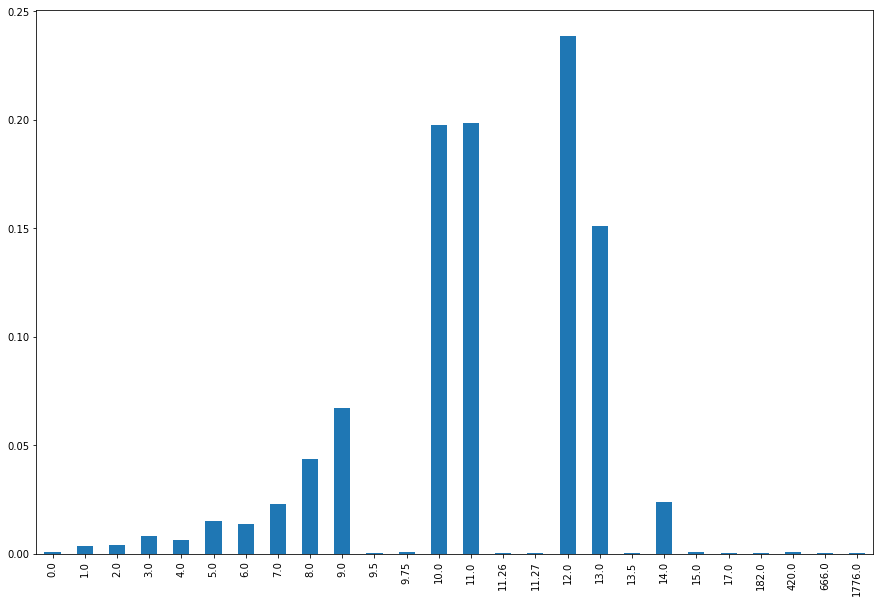

In [26]:
df_tweetarchive_copy.rating_numerator.value_counts(normalize = True).sort_index().plot(kind = 'bar', figsize = [15, 10])

Ratings 182.0, 420.0, 666.0 and 1776.0 are way beyond normal scale range - they are outliers and shall be ignored when doing rating rated analyses. 

#### Code

In [27]:
rating_outliers = [182, 420, 666, 1776]
df_tweetarchive_copy.loc[df_tweetarchive_copy[df_tweetarchive_copy.rating_numerator.isin(rating_outliers)].index, 'rating_numerator'] = np.nan

#### Test

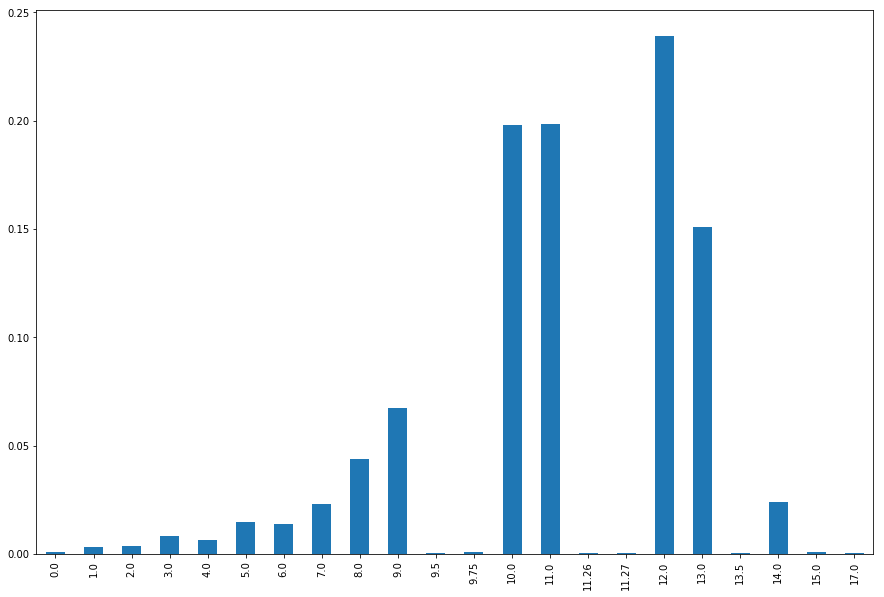

In [28]:
df_tweetarchive_copy.rating_numerator.value_counts(normalize = True).sort_index().plot(kind = 'bar', figsize = [15, 10])

<font color=blue>**Issue**</font> - *source* in *df_tweetarchive* is html anchor tag. To facilicate the analysis, better to convert it into a categorial variable. 

#### Define

1. Extract text element from anchor tag and use the text as value of source
2. Make source a categorial variable

#### Code

In [29]:
df_tweetarchive_copy.source = df_tweetarchive_copy.source.str.extract(r'<a.*?>(.*?)</a>')
df_tweetarchive_copy.source = df_tweetarchive_copy.source.astype('category')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


#### Test

In [30]:
df_tweetarchive_copy.source.dtype

category

In [31]:
df_tweetarchive_copy.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene    91  
Twitter Web Client     33  
TweetDeck              11  
Name: source, dtype: int64

<font color='blue'>**Issue**</font> - column headers *doggo*, *floofer*, *pupper*, *puppo* in *df_tweetarchive* are values, not variable names.

#### Investigate before defining what to do (per reviewer's comments)

In [32]:
# check what values doggo has
df_tweetarchive_copy.doggo.unique()

array(['None', 'doggo'], dtype=object)

In [33]:
# check what values floofer has
df_tweetarchive_copy.floofer.unique()

array(['None', 'floofer'], dtype=object)

In [34]:
# check what values pupper has
df_tweetarchive_copy.pupper.unique()

array(['None', 'pupper'], dtype=object)

In [35]:
# check what values puppo has
df_tweetarchive_copy.puppo.unique()

array(['None', 'puppo'], dtype=object)

In [36]:
# check if any dog is in multple stages
stage = ['doggo', 'floofer', 'pupper', 'puppo']
df_tweetarchive_copy[(df_tweetarchive_copy.loc[:, stage] != 'None').sum(axis = 1) > 1][stage]

,doggo,floofer,pupper,puppo
191,doggo,None,None,puppo
200,doggo,floofer,None,None
460,doggo,None,pupper,None
531,doggo,None,pupper,None
565,doggo,None,pupper,None
575,doggo,None,pupper,None
705,doggo,None,pupper,None
733,doggo,None,pupper,None
778,doggo,None,pupper,None
822,doggo,None,pupper,None


#### Define

1. Add a new column *stage* which is a categorical with values: doggo, pupper, floofer, puppo and combinations 
2. Drop columns doggo, pupper, floofer, puppo

#### Code

In [37]:
# Replace None in doggo, pupper, floofer, puppo with '' and then join them using ' ' 
df_tweetarchive_copy['stage'] = df_tweetarchive_copy[stage].apply(lambda x: x.str.replace('None', '')).apply(lambda x: ' '.join(x), axis = 1)
# Strip whitespace from left and right sides
df_tweetarchive_copy['stage'] = df_tweetarchive_copy['stage'].str.strip()
# Replace space(s) with '|'
df_tweetarchive_copy['stage'] = df_tweetarchive_copy['stage'].str.replace(r'\s+', '|')

#### Test

In [38]:
df_tweetarchive_copy.stage.value_counts()

                 1976
pupper           245 
doggo            83  
puppo            29  
doggo|pupper     12  
floofer          9   
doggo|puppo      1   
doggo|floofer    1   
Name: stage, dtype: int64

In [39]:
# Cross check on the original dataframe
((df_tweetarchive.loc[:, stage] != 'None').sum(axis = 1) > 1).sum()

14

#### Code


In [40]:
# Covert *stage* to categorical
df_tweetarchive_copy.stage = df_tweetarchive_copy.stage.astype('category')
df_tweetarchive_copy.drop(stage, axis = 1, inplace = True)

#### Test

In [41]:
df_tweetarchive_copy.stage.dtype

category

In [42]:
df_tweetarchive_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'name', 'stage'],
      dtype='object')

<font color='blue'>**Issue**</font> - Invalid dog names, such as a, an, the, my ...

#### Define

Reparse text, extract dog names based on the following observations, update column *name*
1. The name usually shows up after 'is', sometimes 'are' if there are more than one dogs. It can also shows up after 'named' or 'Meet'.
2. The first letter of the name is capital.
3. The name may include '
4. When 'are' used, the names appear as XXX and YYY

#### Code

In [50]:
df_tweetarchive_copy['name'] = df_tweetarchive_copy.text.str.extract(r'[is|are|named|Meet|to](\s+[A-Z][a-zA-Z\-\'\s*]+)\.')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


#### Test

In [51]:
df_tweetarchive_copy[df_tweetarchive_copy.name.isin(names_invalid)][['tweet_id', 'text', 'name']]

,tweet_id,text,name


In [52]:
df_tweetarchive_copy[df_tweetarchive_copy.name.str.len() < 3][['tweet_id', 'text', 'name']]

,tweet_id,text,name


In [53]:
df_tweetarchive_copy[df_tweetarchive_copy.name.isnull()].sample(5)[['tweet_id', 'text', 'name']]


,tweet_id,text,name
1466,694342028726001664,It's okay pup. This happens every time I listen to @adele also. 11/10 (vid by @_larirutschmann) https://t.co/oCImpQuoRb,NaN
1150,726224900189511680,I'm getting super heckin frustrated with you all sending in non canines like this ostrich. We only rate dogs... 9/10 https://t.co/Rgbni2Ns8z,NaN
133,866720684873056260,He was providing for his family 13/10 how dare you https://t.co/Q8mVwWN3f4,NaN
589,799308762079035393,RT @dog_rates: I WAS SENT THE ACTUAL DOG IN THE PROFILE PIC BY HIS OWNER THIS IS SO WILD. 14/10 ULTIMATE LEGEND STATUS https://t.co/7oQ1wpf…,NaN
1397,699779630832685056,Take all my money. 10/10 https://t.co/B28ebc5LzQ,NaN


In [54]:
df_tweetarchive_copy[df_tweetarchive_copy.name.isnull()].sample(5)[['tweet_id', 'text', 'name']]

,tweet_id,text,name
1447,696488710901260288,12/10 revolutionary af https://t.co/zKzq4nIY86,NaN
1156,724771698126512129,Nothin better than a doggo and a sunset. 11/10 https://t.co/JlFqOhrHEs,NaN
1600,686007916130873345,This pupper has a magical eye. 11/10 I can't stop looking at it https://t.co/heAGpKTpPW,NaN
195,855138241867124737,RT @frasercampbell_: oh my... what's that... beautiful scarf around your neck... 14/10 a h*ckin good dog in a h*ckin good game @GoodDogsGam…,NaN
1969,673317986296586240,Take a moment and appreciate how these two dogs fell asleep. Simply magnificent. 10/10 for both https://t.co/juX48bWpng,NaN


<font color='blue'>**Issues about image prediction**</font> 
1. Not all images are about dogs. For example, https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg (tweet 666293911632134144) is about a sloth.  
2. In some cases (for example, mulitple objects exist, dogs have costume and etc.), the image classification algorithm fails to detect dogs. For example, in image https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg(tweet 666268910803644416), a dog is sitting in front of a computer behind which a bookcase stands and the computer is playing live-streaming video of the dog! The top 3 predictions are desktop-computer, desk, bookcase. We probably shall use object detection and classification together.

#### Define

1. Add a new column *breed' whose value is
    1. the prediction which is dog and has the highest confidence level
    2. np.nan if none of three predictions is dog</li>
2. Drop columns: p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog

#### Code

In [55]:
# take p1 if p1_dog == True
dog_breed1 = df_imgpredict_copy[df_imgpredict_copy.p1_dog].p1
# take p2 if p1_dog == False and p2_dog == True
dog_breed2 = df_imgpredict_copy[~df_imgpredict_copy.p1_dog & df_imgpredict_copy.p2_dog].p2
# take p3 if p1_dog == False and p2_dog == False and p3_dog == True
dog_breed3 = df_imgpredict_copy[~df_imgpredict_copy.p1_dog & ~df_imgpredict_copy.p2_dog & df_imgpredict_copy.p3_dog].p3
# np.nan if none of three predictions is dog
dog_breednan = pd.Series(data = np.nan, index = df_imgpredict_copy[~df_imgpredict_copy.p1_dog & ~df_imgpredict_copy.p2_dog & ~df_imgpredict_copy.p3_dog].index)
# concatenate all predictions and create a new column breed
dog_breed = [dog_breed1, dog_breed2, dog_breed3, dog_breednan]
# replace '_' and '-' with space, convert to lowercase 
df_imgpredict_copy['breed'] = pd.concat(dog_breed).str.replace(r'_|-', ' ').str.lower()
# convert breed to categorical variable
df_imgpredict_copy.breed = df_imgpredict_copy.breed.astype('category')
# drop columns: p1, p1_conf, p1_dog, p2, p2_conf, p2_dog, p3, p3_conf, p3_dog
df_imgpredict_copy.drop(['p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

#### Test

In [56]:
df_imgpredict_copy.breed.dtype

category

In [57]:
df_imgpredict_copy.breed.value_counts()

golden retriever                  173
labrador retriever                113
pembroke                          96 
chihuahua                         95 
pug                               65 
toy poodle                        52 
chow                              51 
samoyed                           46 
pomeranian                        42 
malamute                          34 
cocker spaniel                    34 
french bulldog                    32 
chesapeake bay retriever          31 
miniature pinscher                26 
cardigan                          23 
staffordshire bullterrier         22 
eskimo dog                        22 
german shepherd                   21 
beagle                            21 
siberian husky                    20 
shih tzu                          20 
maltese dog                       19 
lakeland terrier                  19 
rottweiler                        19 
kuvasz                            19 
shetland sheepdog                 19 
italian grey

In [58]:
df_imgpredict_copy.sample(5)

,tweet_id,jpg_url,img_num,breed
516,676430933382295552,https://pbs.twimg.com/media/CWMqV7WUYAEEClG.jpg,1,golden retriever
693,684225744407494656,https://pbs.twimg.com/media/CX7br3HWsAAQ9L1.jpg,2,golden retriever
1719,819227688460238848,https://pbs.twimg.com/media/C157Oq3WQAEOyHm.jpg,1,border terrier
1607,800513324630806528,https://pbs.twimg.com/media/Cxv-nkJUoAAhzMt.jpg,1,pembroke
1700,817056546584727552,https://pbs.twimg.com/media/C1bEl4zVIAASj7_.jpg,1,kelpie


#### Create master DataFrame

In [59]:
df_tweetapi_copy.rename(index=str, columns={"id": "tweet_id"}, inplace = True)
# merge df_tweetarchive_copy, df_tweetapi_copy, df_imgpredict_copy
df_master = pd.merge(df_tweetarchive_copy, df_tweetapi_copy, on = 'tweet_id', how = 'left')
df_master = pd.merge(df_master, df_imgpredict_copy, on = 'tweet_id', how = 'left')
# rename columns 
df_master.rename(index=str, columns={"rating_numerator": "rating", "jpg_url":"predictimg_url", 'img_num':"predictimg_idx"}, inplace = True)
# reorder columns
columns = ['tweet_id', 'timestamp', 'source', 'retweet_count', 'favorite_count', 'text', 'rating', 'name', 'stage', 'breed', 'predictimg_url', 'predictimg_idx', 'expanded_urls', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'in_reply_to_status_id', 'in_reply_to_user_id']
df_master = df_master.reindex(columns = columns)

In [60]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null category
retweet_count                 2340 non-null float64
favorite_count                2340 non-null float64
text                          2356 non-null object
rating                        2335 non-null float64
name                          1679 non-null object
stage                         2356 non-null category
breed                         1751 non-null category
predictimg_url                2075 non-null object
predictimg_idx                2075 non-null float64
expanded_urls                 2297 non-null object
retweeted_status_id           181 non-null object
retweeted_status_user_id      181 non-null object
retweeted_status_timestamp    181 non-null datetime64[ns]
in_reply_to_status_id         78 non-null object
in_reply_to

In [61]:
df_master.describe()

,tweet_id,retweet_count,favorite_count,rating,predictimg_idx
count,2.356000e+03,2340.000000,2340.000000,2335.000000,2075.000000
mean,7.427716e+17,2931.309402,7966.371368,10.716073,1.203855
std,6.856705e+16,4938.130305,12338.050591,2.172857,0.561875
min,6.660209e+17,0.000000,0.000000,0.000000,1.000000
25%,6.783989e+17,588.750000,1375.500000,10.000000,1.000000
50%,7.196279e+17,1369.000000,3465.500000,11.000000,1.000000
75%,7.993373e+17,3415.250000,9749.750000,12.000000,1.000000
max,8.924206e+17,83716.000000,164376.000000,17.000000,4.000000


In [62]:
df_master.sample(5)

,tweet_id,timestamp,source,retweet_count,favorite_count,text,rating,name,stage,breed,predictimg_url,predictimg_idx,expanded_urls,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,in_reply_to_status_id,in_reply_to_user_id
1419,698342080612007937,2016-02-13 03:05:01,Twitter for iPhone,1007.0,2371.0,This is Maximus. He's training for the tetherball world championship. The grind never stops. 11/10 (vid by @Amuly21) https://t.co/VmFfWMjNkp,11.0,Maximus,,boxer,https://pbs.twimg.com/ext_tw_video_thumb/698341973569245184/pu/img/Sj3A2vSfbKWSv61T.jpg,1.0,https://twitter.com/dog_rates/status/698342080612007937/video/1,NaN,NaN,NaT,NaN,NaN
2292,667160273090932737,2015-11-19 01:59:39,Twitter for iPhone,62.0,257.0,This is Bradlay. He is a Ronaldinho Matsuyama mix. Can also mountain bike (wow). Loves that blue light lime. 11/10 https://t.co/DKhgkMx4N1,11.0,Bradlay,,golden retriever,https://pbs.twimg.com/media/CUI6uuaW4AAvCIs.jpg,1.0,https://twitter.com/dog_rates/status/667160273090932737/photo/1,NaN,NaN,NaT,NaN,NaN
1250,711008018775851008,2016-03-19 01:54:56,Twitter for iPhone,658.0,3131.0,This is Chuckles. He had a balloon but he accidentally let go of it and it floated away. 11/10 hang in there pupper https://t.co/68iNM7B5gW,11.0,Chuckles,pupper,french bulldog,https://pbs.twimg.com/media/Cd4CBQFW8AAY3ND.jpg,1.0,https://twitter.com/dog_rates/status/711008018775851008/photo/1,NaN,NaN,NaT,NaN,NaN
736,780931614150983680,2016-09-28 00:46:20,Twitter for iPhone,8023.0,23107.0,I want to finally rate this iconic puppo who thinks the parade is all for him. 13/10 would absolutely attend https://t.co/5dUYOu4b8d,13.0,NaN,puppo,NaN,https://pbs.twimg.com/media/CtZtJxAXEAAyPGd.jpg,1.0,https://twitter.com/dog_rates/status/780931614150983680/photo/1,NaN,NaN,NaT,NaN,NaN
1901,674646392044941312,2015-12-09 17:46:48,Twitter for iPhone,521.0,1474.0,Two gorgeous dogs here. Little waddling dog is a rebel. Refuses to look at camera. Must be a preteen. 5/10 &amp; 8/10 https://t.co/YPfw7oahbD,5.0,NaN,,flat coated retriever,https://pbs.twimg.com/media/CVzTUGrW4AAirJH.jpg,1.0,https://twitter.com/dog_rates/status/674646392044941312/photo/1,NaN,NaN,NaT,NaN,NaN


## Store, Analyze and Visualize

In [63]:
df_master.to_csv('twitter_archive_master.csv', index = False)

In [64]:
df = pd.read_csv('twitter_archive_master.csv')

In [65]:
df

,tweet_id,timestamp,source,retweet_count,favorite_count,text,rating,name,stage,breed,predictimg_url,predictimg_idx,expanded_urls,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,in_reply_to_status_id,in_reply_to_user_id
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,8322.0,38047.0,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,13.0,Phineas,NaN,NaN,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,https://twitter.com/dog_rates/status/892420643555336193/photo/1,NaN,NaN,NaN,NaN,NaN
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,6148.0,32663.0,"This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",13.0,Tilly,NaN,chihuahua,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,https://twitter.com/dog_rates/status/892177421306343426/photo/1,NaN,NaN,NaN,NaN,NaN
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,4068.0,24578.0,This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,12.0,Archie,NaN,chihuahua,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,https://twitter.com/dog_rates/status/891815181378084864/photo/1,NaN,NaN,NaN,NaN,NaN
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,8470.0,41403.0,This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,13.0,Darla,NaN,labrador retriever,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,https://twitter.com/dog_rates/status/891689557279858688/photo/1,NaN,NaN,NaN,NaN,NaN
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,9164.0,39577.0,"This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",12.0,Franklin,NaN,basset,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",NaN,NaN,NaN,NaN,NaN
5,891087950875897856,2017-07-29 00:08:17,Twitter for iPhone,3048.0,19872.0,Here we have a majestic great white breaching off South Africa's coast. Absolutely h*ckin breathtaking. 13/10 (IG: tucker_marlo) #BarkWeek https://t.co/kQ04fDDRmh,13.0,NaN,NaN,chesapeake bay retriever,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg,1.0,https://twitter.com/dog_rates/status/891087950875897856/photo/1,NaN,NaN,NaN,NaN,NaN
6,890971913173991426,2017-07-28 16:27:12,Twitter for iPhone,2020.0,11617.0,Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,13.0,Jax,NaN,appenzeller,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg,1.0,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",NaN,NaN,NaN,NaN,NaN
7,890729181411237888,2017-07-28 00:22:40,Twitter for iPhone,18466.0,64209.0,When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq,13.0,NaN,NaN,pomeranian,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2.0,"https://twitter.com/dog_rates/status/890729181411237888/photo/1,https://twitter.com/dog_rates/status/890729181411237888/photo/1",NaN,NaN,NaN,NaN,NaN
8,890609185150312448,2017-07-27 16:25:51,Twitter for iPhone,4188.0,27313.0,This is Zoey. She doesn't want to be one of the scary sharks. Just wants to be a snuggly pettable boatpet. 13/10 #BarkWeek https://t.co/9TwLuAGH0b,13.0,Zoey,NaN,irish terrier,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg,1.0,https://twitter.com/dog_rates/status/890609185150312448/photo/1,NaN,NaN,NaN,NaN,NaN
9,890240255349198849,2017-07-26 15:59:51,Twitter for iPhone,7219.0,31336.0,This is Cassie. She is a college pup. Studying

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 18 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null object
source                        2356 non-null object
retweet_count                 2340 non-null float64
favorite_count                2340 non-null float64
text                          2356 non-null object
rating                        2335 non-null float64
name                          1679 non-null object
stage                         380 non-null object
breed                         1751 non-null object
predictimg_url                2075 non-null object
predictimg_idx                2075 non-null float64
expanded_urls                 2297 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id       

In [67]:
df.timestamp = pd.to_datetime(df.timestamp)
df.source = df.source.astype('category')
df.stage = df.stage.astype('category')
df.breed = df.breed.astype('category')

### As time goes, does WeRateDogs trend upward or downward?

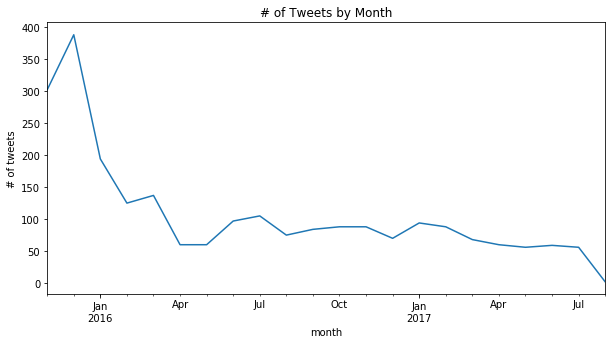

In [144]:
df.groupby(df.timestamp.dt.to_period('M')).agg('count')['tweet_id'].plot(kind = 'line', figsize = [10, 5], title = '# of Tweets by Month')
plt.xlabel('month')
plt.ylabel('# of tweets');

#### We can see that WeRateDogs trends downward as time goes

### What time in a day WeRateDogs is most active ?

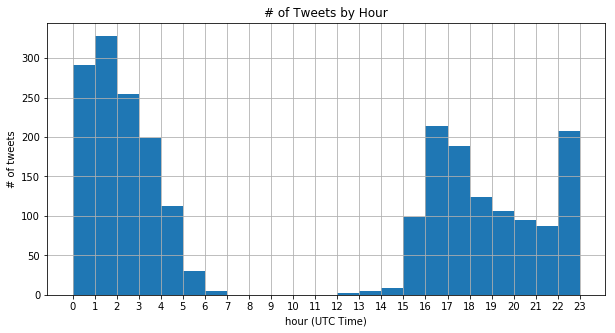

In [160]:
df['hour'] = df.timestamp.dt.hour
hours_bin = np.arange(0, 24, 1)
df.hour.hist(figsize = [10, 5], bins = hours_bin)
plt.xticks(hours_bin);
plt.xlabel('hour (UTC Time)')
plt.ylabel('# of tweets')
plt.title('# of Tweets by Hour');

#### The plot shows that users are most active between 00:00 - 03:00 in UTC (19:00 - 22:00 in EST), followed by 3:00 - 4:00, 16:00 - 18:00, 22:00 - 23:00 UTC (22:00 - 23:00, 11:00 - 13:00, 17:00 - 18:00  in EST)

### Which apps/clients users use the most to post tweets?

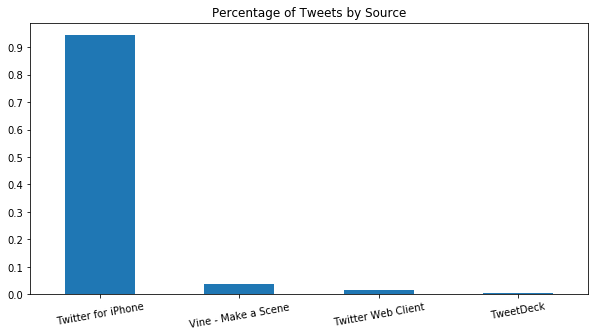

In [161]:
df.source.value_counts(normalize = True).plot(kind = 'bar', figsize = [10, 5], title = 'Percentage of Tweets by Source', yticks = np.arange(0, 1, 0.1), rot = 10);


#### The plot shows that more than 95% tweets were posted from Twitter for iPhone

### Do users tend to rate high or low?

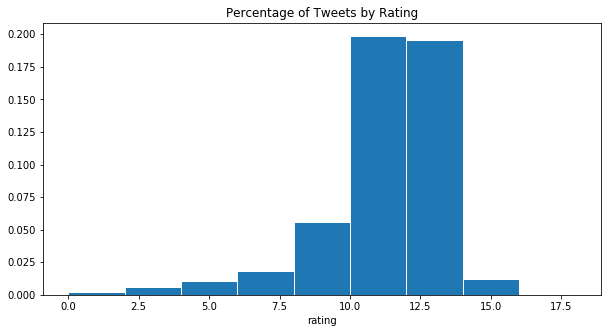

In [162]:
# Distribution of tweets across ratings
bins_rating = np.arange(0, df.rating.max() + 2, 2)
df[~df.rating.isnull()].rating.hist(figsize = [10, 5], bins = bins_rating, density = 1, grid = False, edgecolor='white')
plt.title('Percentage of Tweets by Rating');
plt.xlabel('rating');

#### The plot shows that about 50% ratings are above 8, 40% above 10 

In [195]:
# For the following analysis, only 'General Tweets' are takein into account (See definition of 'General Tweets' by Twitter - https://help.twitter.com/en/using-twitter/types-of-tweets)
df_tweets_general = df[df.retweeted_status_id.isnull()]

### Any correlation between retweet_count and favoriate_count ?

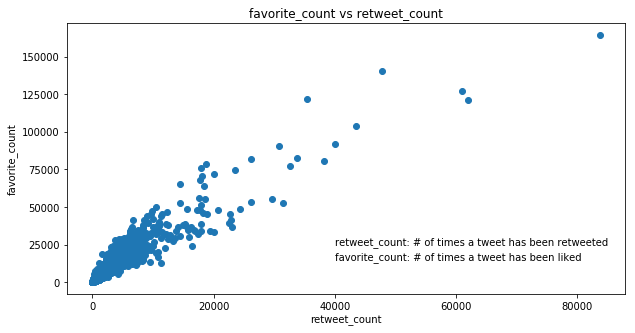

In [182]:
plt.figure(figsize = [10, 5])
plt.scatter(x = df_tweets_general.retweet_count, y = df_tweets_general.favorite_count)
plt.title('favorite_count vs retweet_count')
plt.xlabel('retweet_count')
plt.ylabel('favorite_count')
plt.text(40000, 25000, 'retweet_count: # of times a tweet has been retweeted')
plt.text(40000, 15000, 'favorite_count: # of times a tweet has been liked');

#### The shows that retweet_count and favorite_count are strongly positive correlated - the more frequent a tweet is retweeted, the more likes it gets

### What top 10 popular dog names?

In [245]:
top_names = df_tweets_general.name.value_counts().nlargest(10)
top_names

 Charlie    11
 Cooper     10
 Oliver     10
 Lucy       10
 Tucker     9 
 Penny      8 
 Winston    8 
 Lola       8 
 Daisy      7 
 Toby       6 
Name: name, dtype: int64

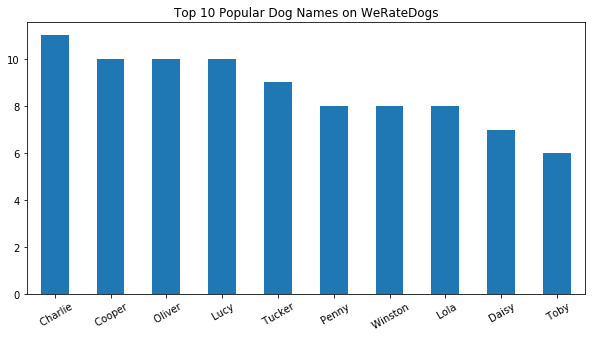

In [246]:
top_names.plot(kind = 'bar', figsize = [10, 5], rot = 30, title = 'Top 10 Popular Dog Names on WeRateDogs');

### What are top 10 popular dog breeds on WeRateDogs ?

In [248]:
top_popular = df_tweets_general.breed.value_counts(normalize = True).nlargest(10)
top_popular

golden retriever      0.093713
labrador retriever    0.064057
pembroke              0.056346
chihuahua             0.053974
pug                   0.036773
toy poodle            0.030249
chow                  0.028470
pomeranian            0.024911
samoyed               0.024911
malamute              0.019573
Name: breed, dtype: float64

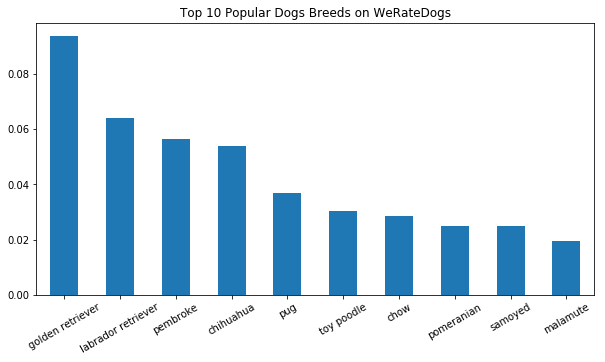

In [249]:
top_popular.plot(kind = 'bar', figsize = [10, 5], rot = 30, title = 'Top 10 Popular Dogs Breeds on WeRateDogs');

### What are top 10 rated dog breeds on WeRateDogs ?

In [228]:
mean_per_breed = df_tweets_general.groupby('breed')[['rating', 'favorite_count']].mean()

In [250]:
top_rated = mean_per_breed.rating.sort_values(ascending = False).nlargest(10)
top_rated

breed
bouvier des flandres    13.000000
saluki                  12.500000
briard                  12.333333
tibetan mastiff         12.250000
border terrier          12.142857
standard schnauzer      12.000000
silky terrier           12.000000
irish setter            11.750000
gordon setter           11.750000
samoyed                 11.690476
Name: rating, dtype: float64

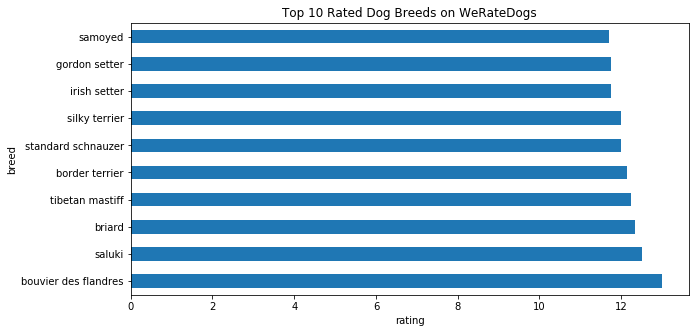

In [251]:
top_rated.plot(kind = 'barh', figsize = [10, 5])
plt.xlabel('rating')
plt.title('Top 10 Rated Dog Breeds on WeRateDogs');

In [285]:
df_tweets_general.groupby('breed').agg('count').rating.loc[top_rated.index]

breed
bouvier des flandres    1 
saluki                  4 
briard                  3 
tibetan mastiff         4 
border terrier          7 
standard schnauzer      1 
silky terrier           1 
irish setter            4 
gordon setter           4 
samoyed                 42
Name: rating, dtype: int64

#### The breed which gets the highest rating (bouvier des flandres) actually has only one rating

In [286]:
top_liked = mean_per_breed.favorite_count.sort_values(ascending = False).nlargest(10)
top_liked

breed
bedlington terrier         24162.166667
saluki                     23230.500000
french bulldog             19643.266667
bouvier des flandres       17291.000000
afghan hound               16563.000000
black and tan coonhound    16374.500000
flat coated retriever      16166.250000
irish water spaniel        15719.666667
leonberg                   14304.333333
whippet                    14073.545455
Name: favorite_count, dtype: float64

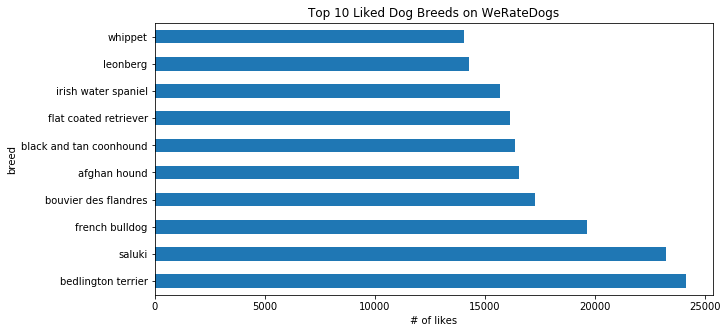

In [253]:
top_liked.plot(kind = 'barh', figsize = [10, 5])
plt.xlabel('# of likes')
plt.title('Top 10 Liked Dog Breeds on WeRateDogs');

In [235]:
top_popular_set = set(top_popular.index.tolist())
top_liked_set = set(top_liked.index.tolist())
top_rated_set = set(top_rated.index.tolist())

In [234]:
common_popular_liked = top_popular_set & top_liked_set
common_popular_liked

set()

In [240]:
common_popular_rated = top_popular_set & top_rated_set
common_popular_rated

{'samoyed'}

In [242]:
common_liked_rated = top_liked_set & top_rated_set
common_liked_rated

{'bouvier des flandres', 'saluki'}

In [243]:
common_liked_rated_popular = top_liked_set & top_rated_set & top_popular_set
common_liked_rated_popular

set()

There is no overlapping between 'top 10 popular' and 'top 10 liked'; only one breed (*samoyed*) shows up in both 'top 10 popular' and 'top 10 rated', two breeds (*bouvier des flandres* and *saluki*) fall into both 'top 10 rated' and 'top 10 liked'

### What is the most retweeted tweet ?

In [309]:
df[df.retweet_count == df.retweet_count.max()]

,tweet_id,timestamp,source,retweet_count,favorite_count,text,rating,name,stage,breed,predictimg_url,predictimg_idx,expanded_urls,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,in_reply_to_status_id,in_reply_to_user_id,hour
1039,744234799360020481,2016-06-18 18:26:18,Twitter for iPhone,83716.0,164376.0,Here's a doggo realizing you can stand in a pool. 13/10 enlightened af (vid by Tina Conrad) https://t.co/7wE9LTEXC4,13.0,NaN,doggo,labrador retriever,https://pbs.twimg.com/ext_tw_video_thumb/744234667679821824/pu/img/1GaWmtJtdqzZV7jy.jpg,1.0,https://twitter.com/dog_rates/status/744234799360020481/video/1,NaN,NaN,NaN,NaN,NaN,18


#### It's funny to see the dog stop swimming when it realizes that it really doesn't need to swim ... check video here: https://twitter.com/dog_rates/status/744234799360020481

### Insights

1. As time goes, WeRateDogs trends downward
2. Users are most active between 00:00 - 03:00 in UTC (19:00 - 22:00 in EST), followed by 3:00 - 4:00, 16:00 - 18:00, 22:00 - 23:00 UTC (22:00 - 23:00 , 11:00 - 13:00, 17:00 - 18:00 in EST)
3. Twitter for iPhone is the most popular app/client to post tweets
4. The more frequent a tweet is retweeted, the more likes it gets. In other words, # of times a tweet is retweeted is strongly positive correlated with # of likes it gets 
5. The most popular dog breed is *golden retriever* 
6. The breed which get the highest rating is *bouvier des flandres* - it actually has only ONE rating
7. The breed which gets the most likes is *bedlington terrier*
8. There is little overlapping between 'top 10 popular breeds', 'top 10 rated breeds' and 'top 10 liked breeds'. From a user's perspective, if I like/retweet a tweet highly depends on the quality of the content: if images/text tells a good story, sends an important message and etc ... it really doesn't depend on the dog's breed ...

#### Limitations

The analysis on *rating* and *breed* is based on a small dataset with errorous data, and hence the insights 5 - 8 may be biased.
1. Out of total 2356 tweets from 11/15/2015 to 08/01/2017, 2175 are non-retweet tweets; out of 2175 non-retweet tweets, 1686 has preditions, ~ 1552 has names, ~ 2154 has ratings
2. names and ratings may not be 100% extracted correctly
3. Image classification system used for this study, in some cases, can't detect dogs in images. Even if it can detect dog and predict its breed, the predition may be wrong.
4. The image-predictions.tsv only includes top 3 predictions for images (a tweet may have multiple images) with the highest top 5 prediction - the truly right prediction may be exluced. 